# Training a network for object detection

This puts everything together.
Please note: I'm not training from scratch.
YOLO is pretrained on imagenet, I simply don't have the resources for that.

So I've used this code: https://github.com/allanzelener/YAD2K
To export tiny yolo in keras format.

From the exported model, I'm cutting off the "regression head".
Only the convolutions up to the last maxpooling are taken, everything after that is new and trained with my setup.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import sys
sys.path.insert(0,"/home/lars/libraries/keras/")
import keras
assert keras.__version__[0] == "2", "we work on version 2 of keras"

Using TensorFlow backend.


In [2]:
from keras.layers import Input
from keras.layers import BatchNormalization, SpatialDropout2D
from keras.layers.pooling import MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model

import keras.backend as K

from keras.callbacks import Callback, ModelCheckpoint

### allow dynamic memory allocation

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

### Load the pretrained model

In [4]:
extraction_model = load_model("models/tiny_320_1088.h5")

/home/lars/libraries/keras/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
extraction_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 1088, 3)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 320, 1088, 16)     432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 1088, 16)     64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 320, 1088, 16)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 544, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 544, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 160, 544, 32)      128       
__________

In [6]:
# the pretrained weights shouldn't be updated any more
# I'm only using them for feature extraction
for layer in extraction_model.layers:
    layer.trainable = False

### Extracting features from the pretrained model
Now I'm taking features from the pretrained model and concatenating them to one big feature map.
This code is meant as a template to take features from any extraction model and merge them.
As you can see, I'm only using the features after the last pooling.
But you could take this code and combine it with vgg16 or something else, then you might want to take intermediate feature maps, too.

The big yolo network has skip connections and does use something like this.

In [7]:
from keras.layers.merge import Concatenate

block3 = extraction_model.get_layer(name="max_pooling2d_4").output
block4 = extraction_model.get_layer(name="max_pooling2d_5").output
block5 = extraction_model.get_layer(name="max_pooling2d_6").output

block3_resized = MaxPool2D((2,2), name="e_maxpool1")(block3)
block4_resized = block4
block5_resized = block5

shape3 = [int(dim) for dim in block3_resized.shape[1:3]]
shape4 = [int(dim) for dim in block4_resized.shape[1:3]]
shape5 = [int(dim) for dim in block5_resized.shape[1:3]]

assert shape3 == shape4, "resolution must be identical"
assert shape4 == shape5, "resolution must be identical"

#extracted_features = Concatenate(axis=-1)([
#    block3_resized, 
#    block4_resized, 
#    block5_resized])
extracted_features = block5_resized
extracted_features.shape.as_list()

[None, 10, 34, 512]

### A new model
This recreates the layout of tiny yolo.
But the layers are not trained yet. This way I can check if the setup really works.

In [8]:
B = 10   # number of anchor boxes
C = 5  # number of classes

In [9]:
# start with the extracted features
conv = extracted_features

# block 1
conv = Conv2D(1024, 3, 
              padding="same",
              use_bias = False,
              kernel_regularizer = keras.regularizers.l2(0.0005),
              name="head_conv1")(conv)
conv = BatchNormalization(name="head_bnorm1")(conv)
conv = LeakyReLU(0.1, name="head_lrelu1")(conv)
conv = SpatialDropout2D(0.3)(conv)

# block 2
conv = Conv2D(1024, 3, 
              padding="same",
              use_bias = False,
              kernel_regularizer = keras.regularizers.l2(0.0005),
              name="head_conv2")(conv)
conv = BatchNormalization(name="head_bnorm2")(conv)
conv = LeakyReLU(0.1, name="head_lrelu2")(conv)
conv = SpatialDropout2D(0.15)(conv)

# output
conv = Conv2D(B *(C+5), 1, 
              padding="same",
              use_bias = True,
              kernel_regularizer = keras.regularizers.l2(0.0005),
              name="head_conv3")(conv)

detection_model = Model(inputs=extraction_model.input, outputs = conv)

### parameters of the model

These are training parameters.
The input and output resolution are important for setting up the boxes as loss for training.
The lambdas are factors to weigh the different loss components against each other.

In [10]:
input_tensor = detection_model.input

in_x = int(input_tensor.shape[1])
in_y = int(input_tensor.shape[2])

output_tensor = detection_model.output

out_x = int(output_tensor.shape[1])
out_y = int(output_tensor.shape[2])

lambda_coords = 10
lambda_class = 2
lambda_obj = 5
lambda_noobj = 0.5

### Set up the training data
Follow the guide on the darknet side to set up VOC:
https://pjreddie.com/darknet/yolo/

In [11]:
# prepare a config for the augmentations
config={}
config["max_hsv_scale"] = [0.2, 0.3, 0.3]
config["max_rotation"] = 10
config["max_shift"] = 0.05
config["zoom_range"] = (0.6,1.4)

In [12]:
train_path= "/home/lars/programming/kitti_labeler/out_split/train.txt"
test_path = "/home/lars/programming/kitti_labeler/out_split/val.txt"

In [13]:
# iterator class to provide data to model.fit_generator
from generator import Augmenter

In [14]:
batch_size=32

# generators for training data and test data
train_gen = Augmenter(train_path, 
                      in_x, in_y, out_x, out_y,
                      B, C, batch_size = batch_size)
val_gen = Augmenter(test_path, 
                      in_x, in_y, out_x, out_y,
                      B, C, batch_size = batch_size)

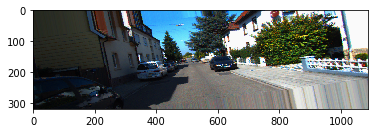

In [15]:
# test the generator
batch = next(train_gen)
imgs = batch[0]
objects = batch[1]
    
plt.imshow(imgs[0, :,:])

# Loss function

The loss function makes use of currying. Therefore this code is a little complicated.
Keras expects a loss in this format loss(y_true, y_pred).

But the loss_func in loss.py needs to know additional parameters such as the network size.
I'm feeding that data by currying the loss_func and providing the additional parameters now.
The result is a function with two remaining parameters and a signature as expected by keras.

This currying can go very wrong, if you mix up the order of the parameters.
If the loss function is called, it prints the parameters it has been given.
Be sure to check this.
Look at model.compile.

In [16]:
# anchor boxes are taken from the tiny yolo voc config
anchors = np.zeros((B, 2))
anchors[:] =np.array([0.18, 0.44, 0.23, 1.35, 0.33, 3.58, 0.43, 0.56, 0.49, 1.87, 0.66, 5.55, 0.99, 2.83, 1.01, 0.83, 1.61,6.34, 3.00,2.70]).reshape((B, 2))

In [17]:
# the anchors are given as width, height
# this doesn't work with numpy's layout
# we have to switch the x and y dimensions
temp = anchors[:,0].copy()
anchors[:,0]=anchors[:,1]
anchors[:,1]= temp

In [18]:
anchors[0]

array([ 0.44,  0.18])

In [19]:
from loss_function import loss_func


meta_data = [anchors, out_x, out_y, B, C, lambda_class, lambda_coords, lambda_obj, lambda_noobj]
loss = loss_func(*meta_data)

# Training the model
Compile with the custom loss, set up a few callbacks and train.

In [20]:
from keras.optimizers import Adam, SGD

# check this: are the parameters correct ?
detection_model.compile(Adam(lr=0.000001), loss)

#detection_model.compile(SGD(lr=1e-4, momentum=0.9, decay = 1e-7), loss)

anchors [[ 0.44  0.18]
 [ 1.35  0.23]
 [ 3.58  0.33]
 [ 0.56  0.43]
 [ 1.87  0.49]
 [ 5.55  0.66]
 [ 2.83  0.99]
 [ 0.83  1.01]
 [ 6.34  1.61]
 [ 2.7   3.  ]]
out_x 10
out_y 34
B 10
C 5
l_class 2
l_coords 10
l_noobj 0.5
l_obj 5


In [21]:
# taken from the keras source
# if the learning rate is too fast, NaNs can occur, stop the training in this case
class TerminateOnNaN(Callback):
    
    def __init__(self):
        self.seen = 0

    def on_batch_end(self, batch, logs=None):
        self.seen += 1
        
        logs = logs or {}
        loss = logs.get('loss')
        
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print('Batch %d: Invalid loss, terminating training' % (batch))
                print("logs: ", logs)
                
                self.model.stop_training = True

In [22]:
nan_terminator = TerminateOnNaN()

# train in small steps and append histories
# if training is interrupted, the history array still contains usable data
import time
histories = []
times = []
for i in range(20):
    history=detection_model.fit_generator(train_gen, 6400//batch_size, 
                                          epochs=5, 
                                          callbacks=[nan_terminator],
                                          validation_data = val_gen,
                                          validation_steps = 1600//batch_size,
                                          #use_multiprocessing=False)
                                          workers =4,
                                          max_queue_size=24)
    histories.append(history)
    times.append(time.time())

Epoch 1/5
200/200 [==============================] - 213s - loss: 17155.8094 - val_loss: 16521.4194
Epoch 2/5
200/200 [==============================] - 201s - loss: 15746.4635 - val_loss: 15657.2608
Epoch 3/5
200/200 [==============================] - 186s - loss: 14533.4116 - val_loss: 14803.4118
Epoch 4/5
200/200 [==============================] - 182s - loss: 13413.6982 - val_loss: 14027.1396
Epoch 5/5
200/200 [==============================] - 183s - loss: 12413.3531 - val_loss: 13141.5394
Epoch 1/5
200/200 [==============================] - 196s - loss: 11504.5667 - val_loss: 12470.5880
Epoch 2/5
200/200 [==============================] - 183s - loss: 10690.0331 - val_loss: 11776.1916
Epoch 3/5
200/200 [==============================] - 183s - loss: 10023.9089 - val_loss: 11078.1965
Epoch 4/5
200/200 [==============================] - 183s - loss: 9390.9060 - val_loss: 10494.1384
Epoch 5/5
200/200 [==============================] - 184s - loss: 8864.0410 - val_loss: 10152.6541
Ep

200/200 [==============================] - 182s - loss: 2565.5135 - val_loss: 4666.8983
Epoch 5/5
200/200 [==============================] - 184s - loss: 2534.8587 - val_loss: 4708.1399
Epoch 1/5
200/200 [==============================] - 197s - loss: 2553.7481 - val_loss: 4552.2487
Epoch 2/5
200/200 [==============================] - 183s - loss: 2553.7353 - val_loss: 4508.9087
Epoch 3/5
200/200 [==============================] - 183s - loss: 2549.4605 - val_loss: 4566.6396
Epoch 4/5
200/200 [==============================] - 182s - loss: 2543.3076 - val_loss: 4828.9953
Epoch 5/5
200/200 [==============================] - 183s - loss: 2582.5824 - val_loss: 4698.9080
Epoch 1/5
200/200 [==============================] - 195s - loss: 2505.7868 - val_loss: 4606.3118
Epoch 2/5
200/200 [==============================] - 183s - loss: 2529.8308 - val_loss: 4738.9823
Epoch 3/5
200/200 [==============================] - 183s - loss: 2503.8862 - val_loss: 4596.0678
Epoch 4/5
200/200 [===========

### Plot the test / val loss
As you can see, the model reaches about 1000 for validation loss.
Then it overfits.

This number can't be interpreted correctly. It depends on the size of the network and the batch.
A solution would be to take the mean in the loss instead of summing all components.
But that would mess with the learning rate.

I'm evaluating the pretrained model against the validation generator.
Surprisingly, the new model reaches better scores.
A possible explanation: The original yolo doesn't use rotations as augmentations. The validation generator uses rotations.
Or the number of samples from the validation set was simply too small

In [23]:
losses = []
val_losses = []

for item in histories:
    losses.extend(item.history["loss"])
    val_losses.extend(item.history["val_loss"])

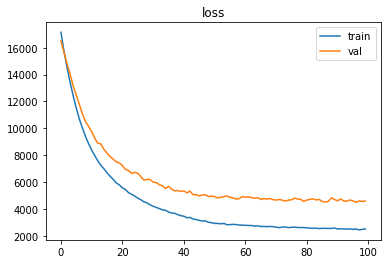

In [24]:

plt.plot(losses)
plt.plot(val_losses)
plt.legend(["train", "val"])
plt.title("loss")
plt.show()

# Evaluation

### Two important helper functions to work with the data
with get_probabilities you can extract the predicted classes, objectness and the combined probability from the output of the network

the extract_from_blob helps with the blob of data fed to the keras loss.
This blob is hard to read, so the function slices the individual parts out of it and converts them to a dictionary

In [25]:
#del extract_from_blob
#del get_probabilities
from utils.prediction import extract_from_blob, get_probabilities

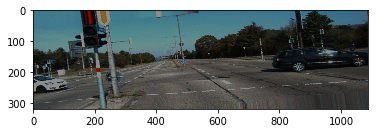

In [65]:
test_gen = val_gen
# get some sample data
batch = next(test_gen)
img = batch[0].copy()

plt.imshow(img[0])
plt.show()

In [66]:
# feed the data to the model
predictions = detection_model.predict(batch[0])
predictions.shape

(32, 10, 34, 100)

### Comparing given objectness with confidence of the network

In [67]:
# extract the given objectness for this image
loss_dict = extract_from_blob(batch[1], out_x, out_y, B, C)

# read the given objectness out of the loss dictionary
f_objectness = loss_dict["f_objectness"].reshape((-1,out_x, out_y, B))

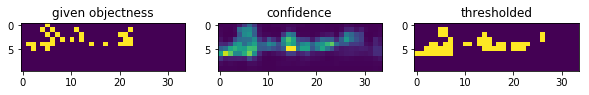

In [68]:
# get the data out of the predictions
classes, objectness, probs = get_probabilities(predictions[0], out_x, out_y, B, C)

# probs is along the B dimension
# for every cell in the output activation map, get the best bounding box score
max_probs = probs.max(axis=-1)

threshold = 0.3
thresholded = max_probs > threshold

f, axes = plt.subplots(1, 3, figsize=(10,10))


axes[0].imshow(f_objectness[0,:,:,0])
axes[0].set_title("given objectness")

axes[1].imshow(max_probs)
axes[1].set_title("confidence")

axes[2].imshow(thresholded)
axes[2].set_title("thresholded")
plt.show()

### Getting the predicted bounding boxes

In [69]:
from utils.activations import np_sigmoid, softmax

from nms import get_detections, apply_nms, idx_to_name

In [70]:
detections = get_detections(predictions[0], threshold, anchors, out_x, out_y, in_x, in_y, B, C)

In [71]:
print("number of detections: ", len(detections))

number of detections:  48


## Non-Max Suppression
Sometimes yolo will predict the same object in more than one cell.
This happens mostly for very big objects where the center of the object is not clear.

We need non-max suppression to remove overlapping bounding boxes.

We apply the non-max suppression to each label separately.

In [72]:
# taken from the yolo repository
names = ["tree trunk",
"traffic light",
"traffic sign",
"lantern",
"pole"]

In [73]:
nms = apply_nms(detections, sess)

In [74]:
nms = idx_to_name(nms, names)

In [75]:
print("we found the following boxes after non-max suppression")
print(nms)

we found the following boxes after non-max suppression
{'pole': [(132, 682, 153, 696), (125, 705, 154, 730), (188, 44, 207, 53), (160, 134, 184, 158), (126, 745, 153, 762)], 'traffic sign': [(163, 484, 181, 502), (164, 167, 181, 188), (165, 462, 180, 477), (136, 556, 155, 565), (138, 583, 155, 592)], 'lantern': [(128, 487, 158, 501), (126, 457, 157, 474), (84, 470, 143, 509), (122, 323, 165, 349), (27, 444, 142, 488)], 'traffic light': [(26, 196, 56, 219), (53, 180, 104, 238), (53, 158, 99, 192)]}


### Plotting the output
I'm using opencv to draw rectangles around all detections
and to write the name in text onto the image.

The image has a very low resolution.
For the output it is upscaled.
The main reason for this is to allow high-res text.

In [76]:
img = batch[0][0]
output_img = img.copy()
dim_x, dim_y = output_img.shape[:2]
factor = 5
output_img = cv2.resize(output_img, (dim_y*factor, dim_x*factor))

for label in nms:
    boxes = nms[label]
    for box in boxes:
        min_x, min_y, max_x, max_y = box
        min_x *= factor
        min_y *= factor
        max_x *= factor
        max_y *= factor
        
    
        cv2.rectangle(output_img,(min_y, min_x),(max_y, max_x),(0,1,0),10)
        #cv2.rectangle(output_img,(min_y-100, min_x-100),(min_y + 100, min_x+100),(0,1,0),-1)
        cv2.putText(output_img, label, (min_y, min_x), cv2.FONT_HERSHEY_SIMPLEX, fontScale=3.5, color=(1, 1, 1), thickness=12)

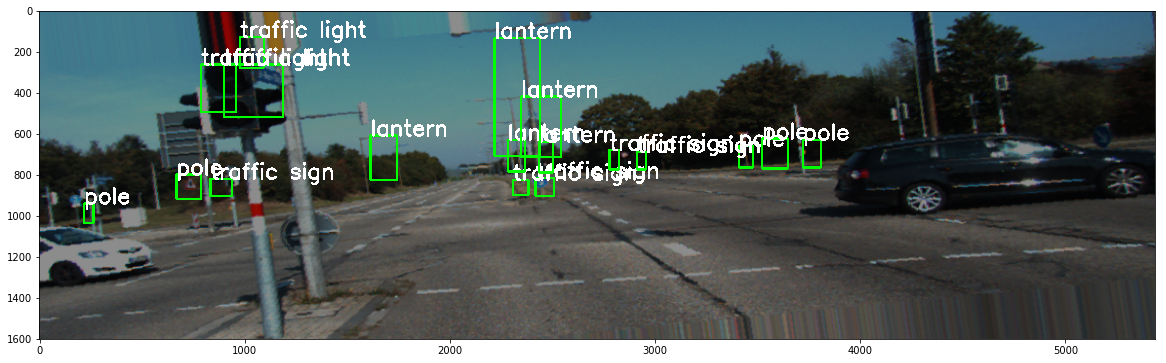

In [77]:
plt.figure(figsize=(20,20))
plt.imshow(output_img)
plt.show()